# Prolific AI Interviewer — LangGraph Walkthrough

This notebook walks through the production interview workflow node by node. It runs the same LangGraph agent that powers the FastAPI service, using live OpenAI calls for question generation and grading so you can observe each confidence update in context.


## Prerequisites
- Install project dependencies (`uv sync` or `pip install -e .`).
- Export a valid `OPENAI_API_KEY` (the notebook stops early if the key is missing).
- Run from the repository root so `src/` is importable.


In [1]:
import sys
from pathlib import Path

root = Path.cwd()
src_dir = root / 'src'
if src_dir.exists() and str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))


# Step 0 - Initial Setup 

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
if not os.getenv("OPENAI_API_KEY"):
    raise EnvironmentError("OPENAI_API_KEY is required for live LLM calls. Set it in your environment or .env file before running these cells.")


from app.core.config import get_settings

settings = get_settings()
print("✅ Environment ready — using live OpenAI calls.")
print(f"Model: {settings.openai_model}  Temperature: {settings.openai_temperature}")


✅ Environment ready — using live OpenAI calls.
Model: gpt-4o-mini  Temperature: 0.4


## Step 1 · Define a Candidate Profile
Provide the same data structure the FastAPI service receives. The helpers in `src/app/service/utils/profile.py` map these fields into skills and evidence spans.


In [3]:
profile = {
    "CANDIDATE_NAME": "Casey Graph",
    "ROLE": "Applied ML Engineer",
    "SKILLS": [
        {
            "taxonomy_id": "machine_learning/pytorch",
            "evidence_sources": [
                {"span": "Led fine-tuning of vision transformers for embedded devices."},
                {"span": "Shipped training pipelines on distributed GPUs."}
            ],
        },
        {
            "taxonomy_id": "machine_learning/langchain-evals",
            "evidence_sources": [
                {"span": "Built eval harnesses for LLM agents measuring precision/recall."}
            ],
        },
        {
            "taxonomy_id": "machine_learning/cuda",
            "evidence_sources": [
                {"span": "Optimised CUDA kernels for low-latency inference."}
            ],
        },
    ],
}
print(f"Profile includes {len(profile['SKILLS'])} claimed skills.")


Profile includes 3 claimed skills.


## Step 2 · Build the Initial Interview State
We call `build_state` exactly like the service: this seeds the priors, UCB/LCB thresholds, and log buffer. `render_skills` mirrors the Streamlit summary table.



In [4]:
from app.agents.interviewer.graph import build_state
from app.service.utils.profile import derive_skills_from_profile, build_spans_map_from_profile
from app.agents.interviewer.utils.state import summarise_skills
from IPython.display import display

skills = derive_skills_from_profile(profile)
spans_map = build_spans_map_from_profile(profile)

max_turns = 10 # Maximum number of turns in the interview
min_questions = 3 # Minimum number of questions to ask
verification_threshold = 3.5 # Minimum score to verify a skill
z_value = 1.64 # Z-value for confidence interval 90%
ucb_c = 2.0 # UCB confidence parameter (higher = more exploration) -> Here we are encouraging exploration

state = build_state(
    skills,
    max_turns,
    min_questions,
    verification_threshold,
    z_value,
    ucb_c,
    spans_map,
)

def render_skills(state):
    rows = summarise_skills(state)
    for row in rows:
        print(row)
    return rows

print(f"Initial skills: {skills}")
_ = render_skills(state) 

Initial skills: ['pytorch', 'langchain-evals', 'cuda']
{'skill': 'pytorch', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.0, 'lcb': 0.86}
{'skill': 'langchain-evals', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.0, 'lcb': 0.86}
{'skill': 'cuda', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.0, 'lcb': 0.86}


## Step 3 · Generate Seed Questions with the LLM
`generate_questions_node` seeds one question per skill so the loop has a fallback even if later LLM calls fail. Each request now includes a short history snippet so follow-ups stay aware of what the candidate already said.


In [5]:
from app.agents.interviewer.nodes.generate import generate_questions_node

state = await generate_questions_node(state)
print(f"Seeded {len(state['question_pool'])} questions.")
for q in state["question_pool"]:
    print(f"- {q.skill} (d={q.difficulty}): {q.text}")


Seeded 3 questions.
- pytorch (d=3): Can you explain how you approached optimizing the training pipeline for your vision transformers on distributed GPUs? What specific techniques or strategies did you find most effective in improving performance?
- langchain-evals (d=3): Can you describe a specific scenario where you implemented an eval harness for an LLM agent? What metrics did you prioritize for measuring its performance and why?
- cuda (d=3): Can you describe a specific optimization technique you used in your CUDA kernels for low-latency inference, and how it impacted performance?


## Step 4 · Select the Next Skill via UCB and Prepare the Follow-up
`select_question_node` scores every active skill with Upper Confidence Bound (mean + exploration bonus), skipping anything already verified or marked inactive. The LLM sees the prior question, grading rationale, and a blunt history transcript so it can chain context-aware follow-ups.


In [7]:
from app.agents.interviewer.nodes.select import select_question_node
from app.agents.interviewer.nodes.ask import ask_node

state = await select_question_node(state)
state = ask_node(state)

current_question = state["current_question"]
print(f"Selected skill: {current_question.skill}")
print(f"Question difficulty ({current_question.difficulty}/5): {current_question.text}\n")
print("Recent UCB logs:")
for log in state["logs"][-3:]:
    print(" •", log)


Selected skill: pytorch
Question difficulty (3/5): Can you walk me through the specific challenges you faced while fine-tuning vision transformers for embedded devices, and how you leveraged PyTorch to overcome those challenges?

Recent UCB logs:
 • select_question → [pytorch] d=3 Can you walk me through the specific challenges you faced wh...
 • select_question → source=llm
 • ask → pytorch: Can you walk me through the specific challenges you faced while fine-tuning visi


## Step 5 · Capture a Candidate Answer
Replace the generated answer with human input if you are running a live interview. Here we call the same OpenAI model for a sample response.


In [8]:
from app.core.llm import get_llm

answer_llm = get_llm(temperature=1)
answer_prompt = (
    "You are a candidate in a technical interview. Answer this interview question as someone proficient in "
    "langchain-evals but unfamiliar with pytorch and cuda. If the question involves pytorch/cuda concepts you don't know, "
    "be honest about your limitations rather than attempting solutions. Keep your response focused and under 3 sentences.\n\n"
    f"Question: {current_question.text}"
)
answer_message = await answer_llm.ainvoke(answer_prompt)
candidate_answer = answer_message.content.strip()

print(candidate_answer)


I specialize in langchain-evals and do not have experience with PyTorch or CUDA, so I cannot provide insights on fine-tuning vision transformers specifically. However, I understand that fine-tuning models for embedded devices often involves challenges like limited memory and processing power. I recommend exploring techniques like model quantization or pruning, which are common approaches in deep learning for optimizing resource usage.


## Step 6 · Grade the Answer and Update the Belief State
`grade_node` calls the LLM grader. `update_node` then runs Welford's incremental stats, recomputes the lower confidence bound (LCB), and updates verified/inactive flags.


In [9]:
from app.agents.interviewer.nodes.grade import grade_node
from app.agents.interviewer.nodes.update import update_node

state["pending_answer"] = candidate_answer
state = await grade_node(state)

grade = state["last_grade"]
print(f"LLM score: {grade.score}/5")
print(f"Reasoning: {grade.reasoning}")

state = update_node(state)
_ = render_skills(state)


LLM score: 1/5
Reasoning: The response indicates a lack of experience with PyTorch and CUDA, which is a critical gap given the question's focus on fine-tuning vision transformers using PyTorch. Additionally, while it mentions relevant challenges and techniques like model quantization and pruning, it fails to provide any specific insights or implementation details related to the use of PyTorch, making the response irrelevant to the question.
{'skill': 'pytorch', 'status': 'inactive', 'n': 1, 'mean': 1.75, 'se': 1.031, 'lcb': 0.06}
{'skill': 'langchain-evals', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.0, 'lcb': 0.86}
{'skill': 'cuda', 'status': 'probing', 'n': 0, 'mean': 2.5, 'se': 1.0, 'lcb': 0.86}


### Confidence Math Explained
- **Welford update** keeps a running mean and spread with one sample at a time—no need to store every score.
- **Standard error guardrail** keeps early intervals fat (min 0.25) so one good answer does not trick us into blind confidence.
- **Lower Confidence Bound (LCB)** = mean − *z* × standard error. Once LCB beats the threshold, the skill is considered verified.
- **Upper Confidence Bound (UCB)** = mean + exploration bonus. It favours believable skills but still rotates through under-sampled ones.


#### Worked Example
Walk through what happens to one skill after repeated answers.
1. **Priors**: we inject two pseudo-samples at mean 2.5 with variance 1.5. Standard error starts ≈ 1.22, giving an ultra-cautious LCB ≈ 0.11.
2. **First answer (score 4)**: Welford folds in the score, mean → 3.00 (weighted with priors) and se stays ≈ 1.22; LCB ≈ 0.61—still far below the 3.75 verification bar.
3. **Second answer (score 4)**: mean creeps toward 3.5, variance tightens, se ≈ 0.70, LCB ≈ 2.13.
4. **Third answer (score 4)**: real_n=3, se floor lifts, se ≈ 0.46 so LCB rises to ≈ 3.10. Only after several strong answers does it cross 3.75.
5. **Missed answer (score 2)**: mean drops and variance widens, pulling LCB right back down—one weak turn quickly erodes confidence.
6. **UCB term**: default “ucb1” mode adds `C * sqrt(log(t) / n_real)` so under-sampled skills get revisited. Switch to `mode='se'` to use `C * se` when you prefer exploration tied to statistical uncertainty.


In [10]:
from app.agents.interviewer.utils.stats import (
    compute_uncertainty,
    effective_sample_count,
    ensure_prior,
    welford_update,
)

def describe(scores, z=1.64):
    belief = {}
    ensure_prior(belief)
    compute_uncertainty(belief, z, add_ucb=True)
    print(f"n={effective_sample_count(belief)} → mean={belief['mean']:.2f}, se={belief['se']:.2f}, LCB={belief['lcb']:.2f}")
    for score in scores:
        welford_update(belief, score)
        compute_uncertainty(belief, z, add_ucb=True)
        print(f"n={effective_sample_count(belief)} → mean={belief['mean']:.2f}, se={belief['se']:.2f}, LCB={belief['lcb']:.2f}")

print('Two consistent scores of 4:')
describe([4, 4, 5, 5,5,5,5])

print('Add a weaker score of 2:')
describe([5, 2, 2])


Two consistent scores of 4:
n=0 → mean=2.50, se=1.00, LCB=0.86
n=1 → mean=3.25, se=1.03, LCB=1.56
n=2 → mean=3.50, se=0.65, LCB=2.44
n=3 → mean=3.88, se=0.59, LCB=2.91
n=4 → mean=4.10, se=0.51, LCB=3.26
n=5 → mean=4.25, se=0.44, LCB=3.52
n=6 → mean=4.36, se=0.39, LCB=3.72
n=7 → mean=4.44, se=0.35, LCB=3.87
Add a weaker score of 2:
n=0 → mean=2.50, se=1.00, LCB=0.86
n=1 → mean=3.75, se=1.44, LCB=1.39
n=2 → mean=3.17, se=1.01, LCB=1.50
n=3 → mean=2.88, se=0.77, LCB=1.61


## Step 7 · Decide Whether to Continue
`decide_node` stops once we hit the turn cap, all skills are verified, or nothing is left to probe.


In [11]:
from app.agents.interviewer.nodes.decide import decide_node

command = decide_node(state)
print(f"Next action: {command.goto}")

print("\nLatest logs:")
for entry in state["logs"][-8:]:
    print(" •", entry)


Next action: select

Latest logs:
 • select_ucb → → select pytorch (UCB=4.165)
 • select_question → [pytorch] d=3 Can you walk me through the specific challenges you faced wh...
 • select_question → source=llm
 • ask → pytorch: Can you walk me through the specific challenges you faced while fine-tuning visi
 • grade → 1 (The response indicates a lack of experience with PyTorch and CUDA, which is a critical gap given the question's focus on fine-tuning vision transformers using PyTorch. Additionally, while it mentions relevant challenges and techniques like model quantization and pruning, it fails to provide any specific insights or implementation details related to the use of PyTorch, making the response irrelevant to the question.)
 • update → pytorch: n=1 mean=1.75 SE=1.031 LCB=0.06
 • status → verified=False inactive=True
 • decide → continue


## Step 8 · Running Additional Turns (Optional)
Wrap the steps above in a helper to simulate a full interview. Swap in human answers to mirror the service loop.



=== Turn 1 ===

Next skill: pytorch
Question (3/5): Can you describe your experience with optimizing PyTorch models for performance on embedded devices? What specific techniques or strategies did you find most effective?

Candidate answer:
I don't have experience with optimizing PyTorch models or working with CUDA, as my expertise lies primarily in langchain-evals. However, I understand that optimizing models for embedded devices typically involves techniques like model quantization and pruning, which I can discuss conceptually. For specific implementation details, I would need to rely on resources or colleagues with more experience in PyTorch.

LLM score: 2/5
Reasoning: The response acknowledges a lack of personal experience with optimizing PyTorch models, which is a significant gap given the question's focus. While it mentions relevant techniques like model quantization and pruning, it does so in a vague and conceptual manner without providing any specific implementation details or 

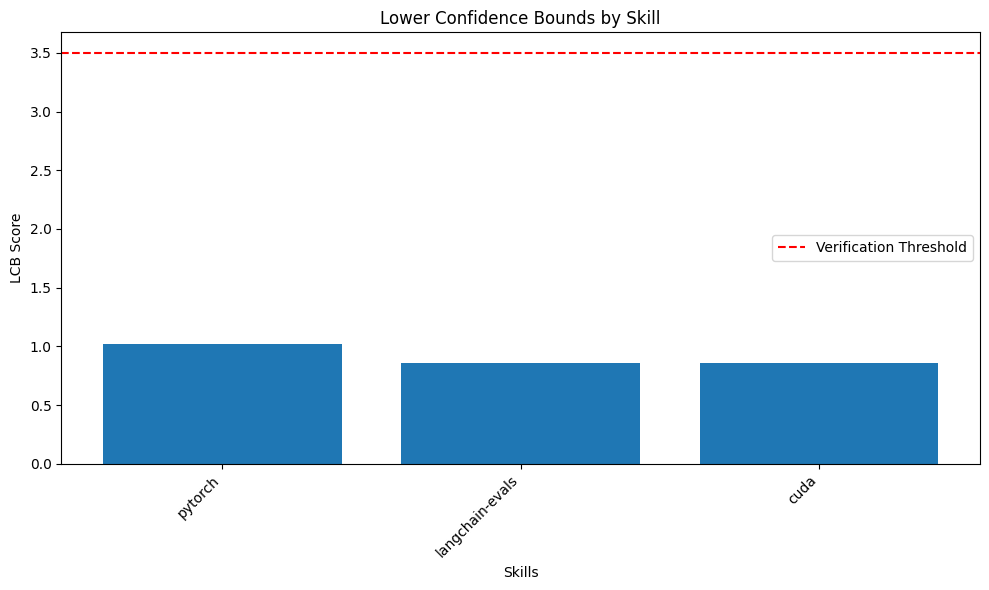


=== Turn 2 ===

Next skill: langchain-evals
Question (2/5): Can you share a specific example of how you've implemented langchain-evals in a project, particularly focusing on the metrics you measured and the outcomes you achieved?

Candidate answer:
In a recent project, I implemented langchain-evals to evaluate the performance of various language models on text generation tasks. I focused on metrics such as BLEU scores and perplexity to assess the quality of generated outputs. The outcomes showed a significant improvement in BLEU scores after fine-tuning the models, indicating better alignment with human-like text generation.

LLM score: 4/5
Reasoning: The response provides a specific example of implementing langchain-evals in a project, focusing on relevant metrics like BLEU scores and perplexity. It demonstrates a clear understanding of the evaluation process and the outcomes achieved, though it lacks detailed implementation steps or code examples that could enhance the technical dep

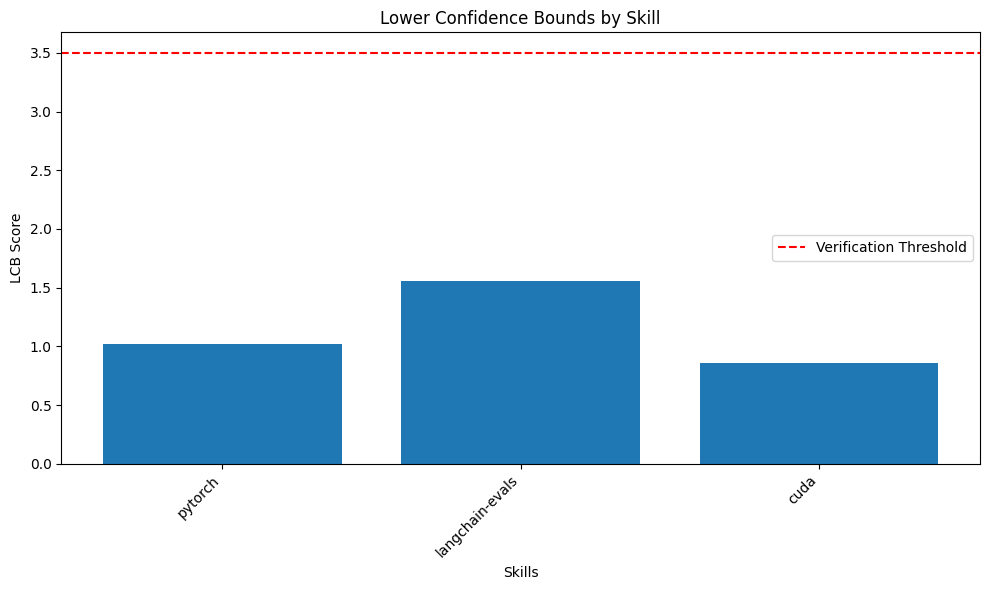


=== Turn 3 ===

Next skill: langchain-evals
Question (4/5): Can you explain how you integrated langchain-evals with your existing model training pipeline, and what challenges you faced during that integration?

Candidate answer:
I integrated langchain-evals into my model training pipeline by using it to evaluate the performance of language models based on specific metrics, ensuring that the outputs align with expected results. One challenge I faced was adapting the evaluation metrics to fit the unique requirements of my models, which required some customization. However, I am not familiar with PyTorch or CUDA, so I relied on existing documentation and community resources for any necessary adjustments related to those technologies.

LLM score: 3/5
Reasoning: The response provides a basic overview of how langchain-evals was integrated into the model training pipeline and mentions a specific challenge regarding the adaptation of evaluation metrics. However, it lacks concrete implementati

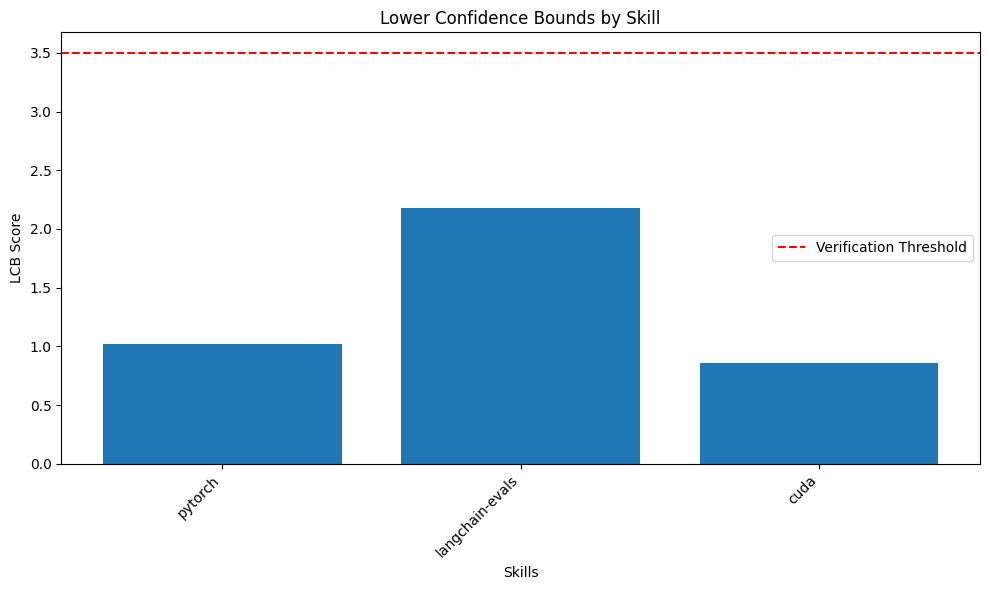


=== Turn 4 ===

Next skill: cuda
Question (3/5): Can you describe a specific project where you optimized CUDA kernels for low-latency inference? What techniques did you use, and what improvements did you observe in performance?

Candidate answer:
I appreciate the question, but I must admit that I don't have experience with optimizing CUDA kernels or working directly with PyTorch. My expertise lies primarily in langchain-evals, where I focus on evaluating language models and optimizing their performance in that context. If you have questions related to langchain-evals, I'd be happy to discuss those!

LLM score: 1/5
Reasoning: The response does not address the question regarding optimizing CUDA kernels for low-latency inference and admits a lack of experience in this area. This indicates a fundamental lack of relevant knowledge or experience, resulting in a score of 1.
{'skill': 'pytorch', 'status': 'probing', 'n': 1, 'mean': 2.25, 'se': 0.75, 'lcb': 1.02}
{'skill': 'langchain-evals', '

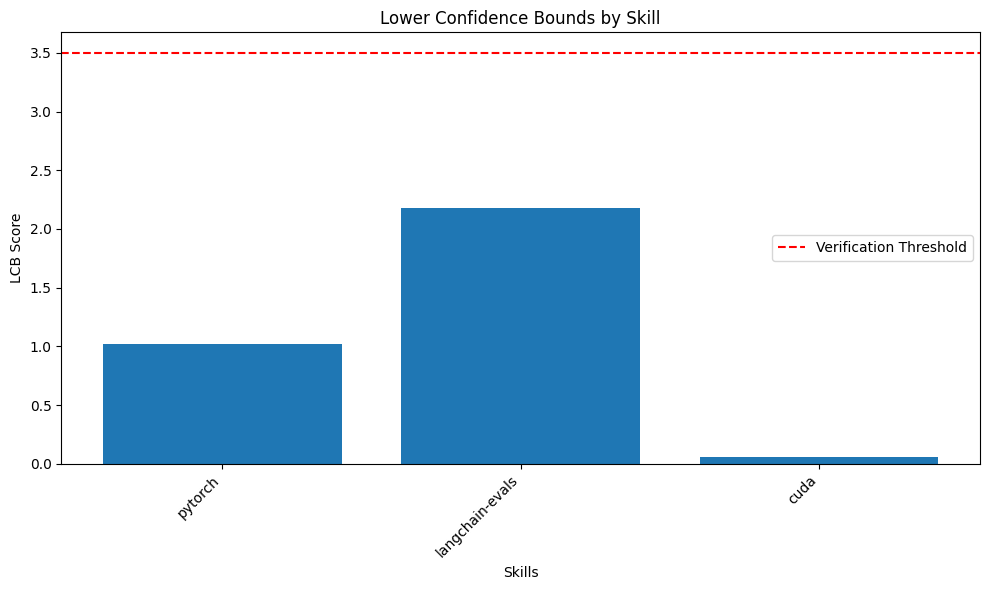


=== Turn 5 ===

Next skill: langchain-evals
Question (2/5): Can you describe a specific metric you found particularly useful when evaluating language models with langchain-evals, and how it influenced your decision-making process in a project?

Candidate answer:
One metric I found particularly useful when evaluating language models with langchain-evals is the F1 score, as it provides a balance between precision and recall, helping to assess the model's accuracy in generating relevant responses. This influenced my decision-making by guiding me to select models that not only produced correct outputs but also minimized false positives and negatives, ensuring a more reliable performance in real-world applications. Overall, focusing on the F1 score helped me prioritize models that aligned better with the project's goals.

LLM score: 4/5
Reasoning: The response correctly identifies the F1 score as a useful metric for evaluating language models, explaining its relevance in balancing precisio

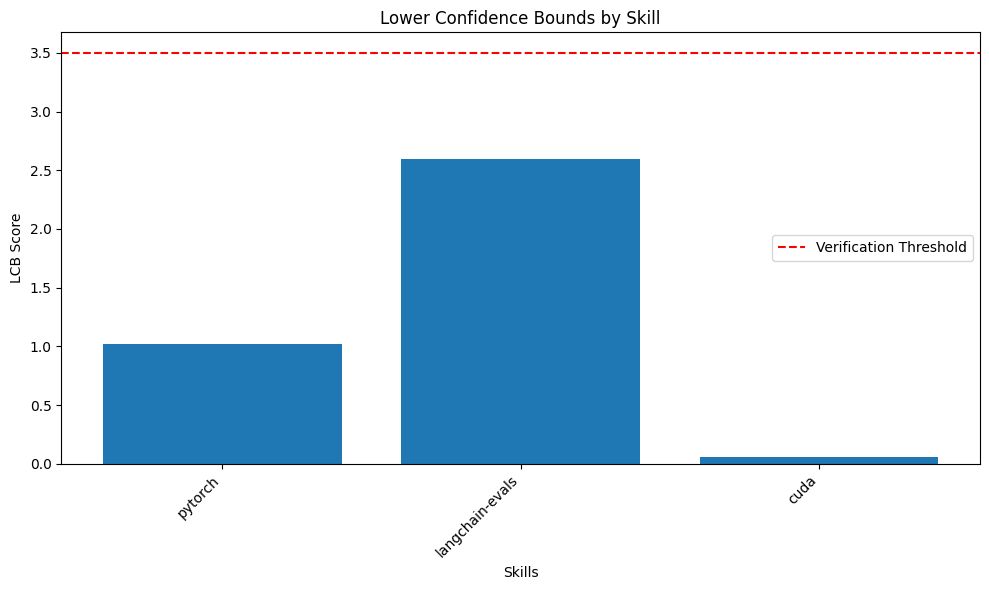


=== Turn 6 ===

Next skill: langchain-evals
Question (4/5): Can you discuss any specific challenges you encountered while measuring the F1 score using langchain-evals, and how you addressed those challenges in your evaluation process?

Candidate answer:
While using langchain-evals to measure the F1 score, I encountered challenges related to ensuring the correct handling of class imbalances in the dataset, which could skew the results. To address this, I implemented stratified sampling to maintain the distribution of classes in both training and evaluation sets. Additionally, I made sure to validate the evaluation metrics by cross-referencing with other scoring methods to ensure consistency.

LLM score: 4/5
Reasoning: The response demonstrates a strong understanding of the challenges associated with measuring the F1 score, specifically addressing class imbalance and the use of stratified sampling. However, it lacks specific implementation details or code examples that could further enh

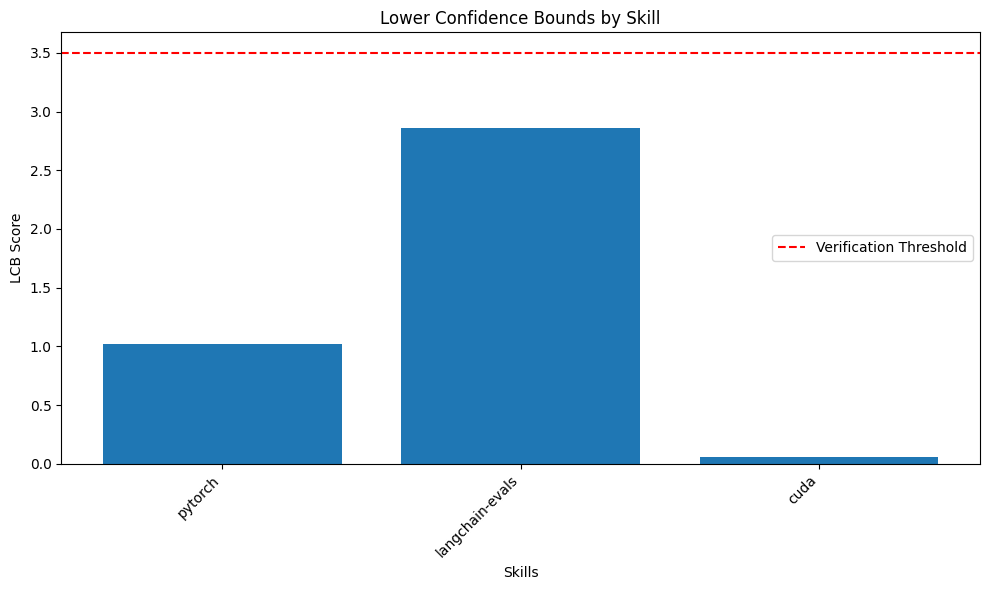


=== Turn 7 ===

Next skill: pytorch
Question (4/5): Can you share some specific techniques you used to fine-tune vision transformers for embedded devices? What were the key considerations you kept in mind during the optimization process?

Candidate answer:
I specialize in langchain-evals and don't have experience with fine-tuning vision transformers or working with PyTorch and CUDA. However, I understand that key considerations for optimizing models for embedded devices typically include reducing model size through techniques like quantization and pruning, as well as ensuring efficient inference to meet resource constraints. For detailed implementation, I would recommend consulting resources specific to PyTorch and embedded systems.

LLM score: 1/5
Reasoning: The response fails to address the question about fine-tuning vision transformers specifically and instead focuses on general techniques for optimizing models for embedded devices without any relevant experience or details. This l

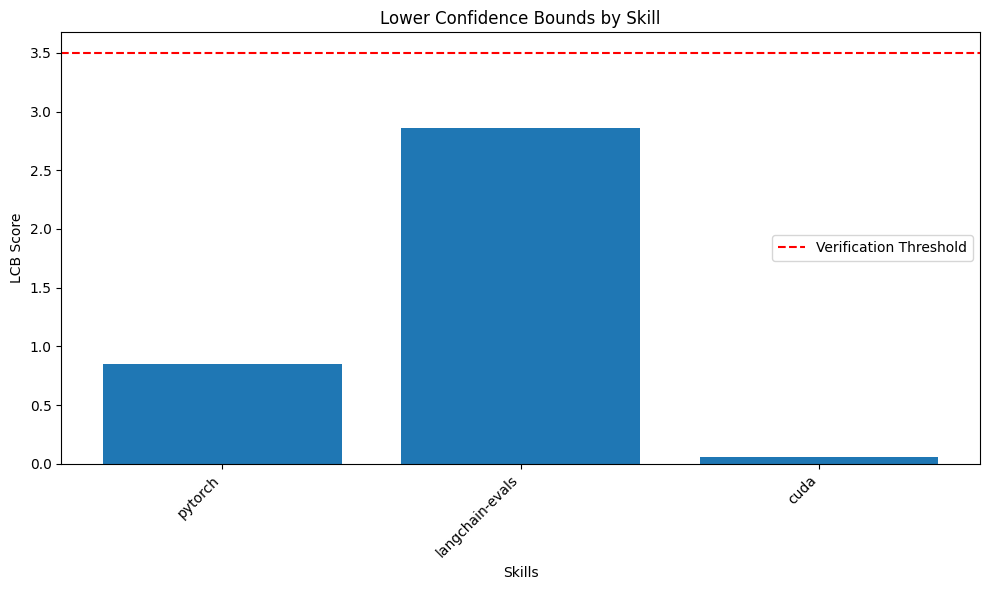


=== Turn 8 ===

Next skill: langchain-evals
Question (2/5): Can you share an example of how you used langchain-evals to improve the performance of a language model, and what specific insights you gained from the evaluation results?

Candidate answer:
I recently used langchain-evals to assess the performance of a language model by implementing various evaluation metrics like accuracy and F1 score on a specific task. The insights gained highlighted areas where the model struggled, particularly in understanding context, which led to targeted fine-tuning and improved overall performance. However, I don't have experience with PyTorch or CUDA, so I can't speak to any model training or optimization processes involving those technologies.

LLM score: 3/5
Reasoning: The response provides a mostly correct overview of using langchain-evals to assess a language model's performance, mentioning specific metrics like accuracy and F1 score. However, it lacks detailed implementation steps or concrete 

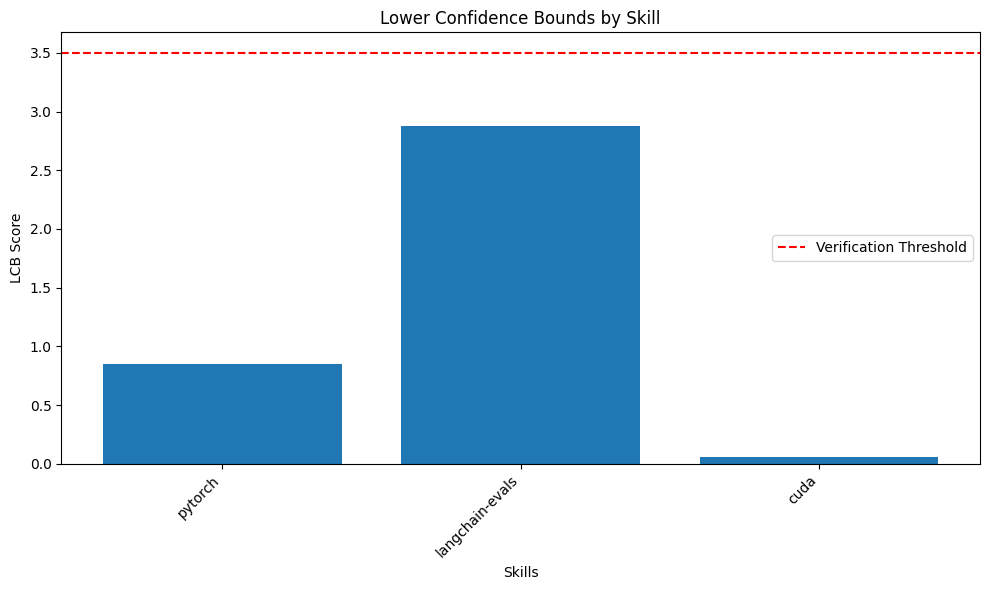


=== Turn 9 ===

Next skill: langchain-evals
Question (3/5): Can you explain how you handled class imbalance when using langchain-evals, and what strategies you found effective in ensuring a fair evaluation of your language model's performance?

Candidate answer:
In langchain-evals, I addressed class imbalance by utilizing stratified sampling to ensure that each class was adequately represented in the evaluation dataset. Additionally, I implemented metrics such as precision, recall, and F1-score to provide a more nuanced understanding of the model's performance across different classes. These strategies helped ensure a fair evaluation despite the imbalance in the dataset.

LLM score: 4/5
Reasoning: The response correctly identifies the use of stratified sampling to address class imbalance, which is a concrete and effective strategy. It also mentions relevant evaluation metrics like precision, recall, and F1-score, demonstrating a clear understanding of how to assess model performance. 

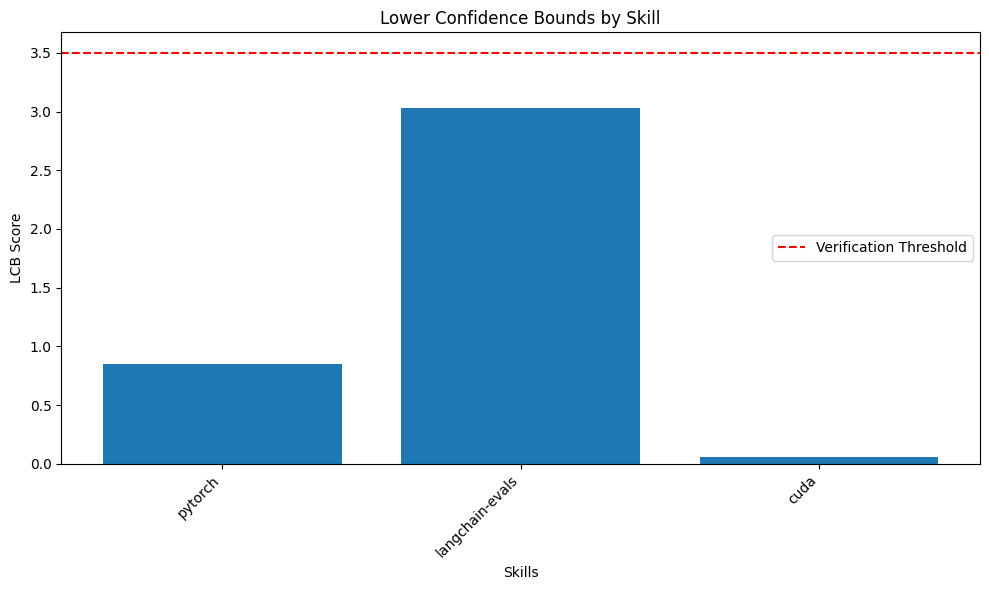


=== Turn 10 ===

Next skill: langchain-evals
Question (4/5): Can you provide an example of a specific evaluation metric you found particularly useful in your langchain-evals implementation, and explain how it influenced your model tuning process?

Candidate answer:
In my langchain-evals implementation, I found the F1 score particularly useful as it balances precision and recall, making it effective for evaluating models in scenarios with imbalanced classes. This metric guided my model tuning process by highlighting the trade-offs between false positives and false negatives, allowing me to adjust thresholds and improve overall model performance. By focusing on the F1 score, I was able to iteratively refine my model to better meet the specific needs of the task at hand.

LLM score: 4/5
Reasoning: The response correctly identifies the F1 score as a useful evaluation metric and explains its relevance in the context of imbalanced classes. It also describes how the F1 score influenced the m

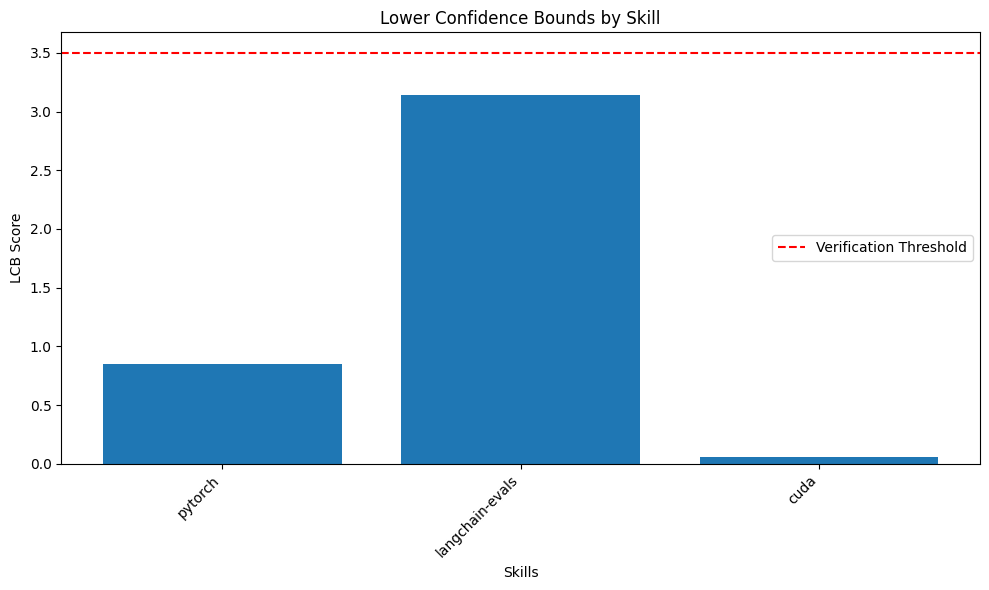

Interview complete per policy.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

from app.agents.interviewer.graph import build_graph, build_state
from app.agents.interviewer.nodes.grade import grade_node
from app.agents.interviewer.nodes.update import update_node
from app.agents.interviewer.nodes.decide import decide_node
from app.core.llm import get_llm

# Rebuild a fresh state so we can replay multiple turns
state = build_state(
    skills,
    max_turns,
    min_questions,
    verification_threshold,
    z_value,
    ucb_c,
    spans_map,
)

workflow = build_graph(interrupt_after=["ask"])

def plot_skill_lcbs(state):
    """Plot the LCB values for each skill."""
    skill_data = []
    for summary in state["skill_summaries"]:
        skill_data.append({
            'skill': summary['skill'],
            'lcb': summary['lcb'],
            'mean': summary['mean'],
            'verified': summary['skill'] in state.get('verified_skills', [])
        })
    
    df = pd.DataFrame(skill_data)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['skill'], df['lcb'])
    plt.axhline(y=verification_threshold, color='r', linestyle='--', label='Verification Threshold')
    
    # Color verified skills differently
    for i, bar in enumerate(bars):
        if df['verified'].iloc[i]:
            bar.set_color('green')
    
    plt.title('Lower Confidence Bounds by Skill')
    plt.xlabel('Skills')
    plt.ylabel('LCB Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

async def run_turn(state, answer: Optional[str] = None):
    """Advance the graph to the next question, capture an answer, then grade/update."""
    try:
        turn_state = await workflow.ainvoke(state)
    except GraphInterrupt as interrupt:
        turn_state = dict(interrupt.state.values)

    question = turn_state["current_question"]
    if question is None:
        print("Interview already complete per policy.")
        return turn_state

    print(f"\nNext skill: {question.skill}")
    print(f"Question ({question.difficulty}/5): {question.text}")

    if answer is None:
        llm = get_llm(temperature=0.3)
        msg = await llm.ainvoke(
            f"You are a candidate in a technical interview. Answer this interview question as someone proficient in "
            f"langchain-evals but unfamiliar with pytorch and cuda. If the question involves pytorch/cuda concepts you don't know, "
            f"be honest about your limitations rather than attempting solutions. Keep your response focused and under 3 sentences.\n\n"
            f"Question: {question.text}"
            f"{question.text}"
        )
        answer = msg.content.strip()

    print("\nCandidate answer:")
    print(answer)

    turn_state["pending_answer"] = answer
    turn_state = await grade_node(turn_state)
    grade = turn_state["last_grade"]
    print(f"\nLLM score: {grade.score}/5")
    print(f"Reasoning: {grade.reasoning}")

    turn_state = update_node(turn_state)
    render_skills(turn_state)
    plot_skill_lcbs(turn_state)
    return turn_state

async def simulate_interview(state, max_turns: int = 6):
    for turn in range(max_turns):
        print(f"\n=== Turn {turn + 1} ===")
        state = await run_turn(state)
        if decide_node(state).goto != "select":
            print("Interview complete per policy.")
            break
    return state

state = await simulate_interview(state, max_turns=10)
